code to run one time inference on handwritten digit images

'# ->' means that particular cell is important and it has to be executed for inferencing

In [ ]:
!pip install pycoral

In [6]:
# ->
import os
import cv2 as cv
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from pycoral.utils import edgetpu
from pycoral.utils import dataset
from pycoral.adapters import common
from pycoral.adapters import classify


ModuleNotFoundError: No module named 'pycoral.utils'

In [4]:
# ->
# Specify the TensorFlow model, labels, and image
model_file = 'handwriting_model2_quant_edgetpu.tflite'
label_file = 'digits_labels.txt'
image_file = '2_img.GIF'

In [41]:
# ->
# Initialize the TF interpreter
interpreter = edgetpu.make_interpreter(model_file)
interpreter.allocate_tensors()


In [42]:
# ->
# Model must be uint8 quantized
if common.input_details(interpreter, 'dtype') != np.uint8:
    raise ValueError('Only support uint8 input type.')
else:
    print('model is quantized, ready to use')

model is quantized, ready to use


In [12]:
# testing image
try: 
    img  = Image.open(image_file) 
    img.show()
except IOError:
    pass

In [66]:
# Resize the image
size = common.input_size(interpreter)
print(size)
image = Image.open(image_file).convert('RGB').resize(size, Image.ANTIALIAS)
img_array = np.array(Image.open(image_file).convert('RGB').resize(size, Image.ANTIALIAS))
#print(image.size)


(28, 28)


In [7]:
# ->
# resizing with greyscale
size = common.input_size(interpreter)
#image = Image.open(image_file).convert('L').resize(size, Image.ANTIALIAS)
grey_img = ImageOps.grayscale(Image.open(image_file).convert('RGB').resize(size, Image.ANTIALIAS))
img_array = np.array(grey_img)
img_array.shape

(28, 28)

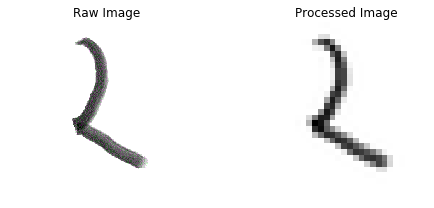

In [44]:
# plotting the images
fig = plt.figure(figsize=(7, 3))

fig.add_subplot(1, 2, 1)
plt.imshow(Image.open(image_file))
plt.axis('off')
plt.title("Raw Image")

fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.title("Processed Image")
plt.imshow(img_array, cmap='gray')

In [8]:
# getting image size 
im = cv.imread('1_img.GIF')
print(im.shape)

AttributeError: 'NoneType' object has no attribute 'shape'

In [45]:
# broadcasting array
#image = np.array(np.zeros((28, 28)), np.ones((28,1))) + image
a = np.zeros((28,28,1))

for row in range(0,27):
    for col in range(0,27):
        a[row][col][0] = img_array[row][col]

print(a)
#print(img_array.shape)

ValueError: setting an array element with a sequence.

In [9]:
# ->
# first broadcasting img_array to fit dimentions (28, 28, 1)
img_array = img_array.reshape((28,28,1))
img_array.shape

(28, 28, 1)

In [67]:
# default parameters for manual input processing
top_k = 1
threshold = 0.0
count = 1
input_mean = 128.0
input_std = 128.0

In [70]:
# Manual image preprocessing - 2 transformations: normalization and quantization
# combined in 1 line: q = (input - mean) / (std * scale) + zero_point
# 1e-5 used instead of 0 to prevent division by 0 error
params = common.input_details(interpreter, 'quantization_parameters')
print(params)
scale = params['scales']
zero_point = params['zero_points']

# default parameters used
mean = input_mean
std = input_std

if abs(scale * std - 1) < 1e-5 and abs(mean - zero_point) < 1e-5:
    # Input data does not require preprocessing.
    print('no preprocessing required')
    common.set_input(interpreter, image)
else:
    # Input data requires preprocessing
    print('image preprocessed')
    img_array = img_array.reshape((28,28,1))
    normalized_input = (img_array - mean) / (std * scale) + zero_point
    np.clip(normalized_input, 0, 255, out=normalized_input)
    common.set_input(interpreter, normalized_input.astype(np.uint8))


{'scales': array([1.], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}
image preprocessed


In [46]:
# ->
# Run an inference
common.set_input(interpreter, img_array)
interpreter.invoke()
classes = classify.get_classes(interpreter, top_k=1)
print(classes)

[Class(id=2, score=0.859375)]


In [47]:
# Print the result
labels = dataset.read_label_file(label_file)
print("class | score")
for c in classes:
    print('%s     | %.5f' % (labels.get(c.id, c.id), c.score))
    #print(c.score)

class | score
2     | 0.85938
